# Needle Insertion Markov Decision Process

In [1]:
using POMDPs
using Distributions
using POMDPToolbox
using PyPlot
using JLD
importall Base

## States

In [2]:
type NeedleState 
    x::Int64 # x position
    y::Int64 # y position
    psi::Int64 # orientation
    done::Bool # are we in a terminal state?
end

In [3]:
# initial state constructor
NeedleState(x::Int64, y::Int64, psi::Int64) = NeedleState(x,y,psi,false)
# checks if the position of two states are the same
posequal(s1::NeedleState, s2::NeedleState) = s1.x == s2.x && s1.y == s2.y && s1.psi == s2.psi
# copies state s2 to s1
function Base.copy!(s1::NeedleState, s2::NeedleState) 
    s1.x = s2.x
    s1.y = s2.y
    s1.psi = s2.psi
    s1.done = s2.done
    s1
end

Base.hash(s::NeedleState, h::UInt64 = zero(UInt64)) = hash(s.x, hash(s.y, hash(s.psi, hash(s.done, h))))
Base.isequal(s1::NeedleState,s2::NeedleState) = (s1.x == s2.x && s1.y == s2.y && s1.psi == s2.psi && s1.done == s2.done);
==(s1::NeedleState, s2::NeedleState) = (s1.x == s2.x && s1.y == s2.y && s1.psi == s2.psi && s1.done == s2.done);

## POMDP

In [4]:
# the needle mdp type
type Needle <: POMDP{NeedleState, Symbol, NeedleState} # Note that our MDP is parametarized by the state and the action
    size_x::Int64 # x size of the grid
    size_y::Int64 # y size of the grid
    size_psi::Int64 # number of orientation bins
    reward_states::Vector{NeedleState} # target/obstacle states
    reward_values::Vector{Float64} # reward values for those states
    tprob::Array{Float64} # probability of transitioning to the desired state
    discount_factor::Float64 # disocunt factor
end

In [5]:
# we use key worded arguments so we can change any of the values we pass in 
function Needle(;sx::Int64 = 11, # size_x
                sy::Int64 = 11, # size_y
                spsi::Int64 = 8, # size_psi
#                 rs::Vector{NeedleState} = [[NeedleState(5,4,psi) for psi = 1:spsi]; # target states
#                                             [NeedleState(4,6,psi) for psi = 1:spsi]; # obstacle states
#                                             [NeedleState(6,6,psi) for psi = 1:spsi]; # obstacle states
#                                             [NeedleState(7,4,psi) for psi = 1:spsi]; # obstacle states
#                                             [NeedleState(0,y,psi) for y = 0:sy-1, psi = 3:7][:]; # boundary states
#                                             [NeedleState(sx,y,psi) for y = 0:sy-1, psi = [1:3;7:spsi]][:];
#                                             [NeedleState(x,0,psi) for x = 1:sx-2, psi = [5:spsi;1]][:];
#                                             [NeedleState(x,sy,psi) for x = 1:sx-2, psi = 1:5][:]],
#                 rv::Vector{Float64} = [fill(100.0,spsi); fill(-20.0,spsi*3); fill(-100,(2*sx+2*sy-4)*5)],
                rs::Vector{NeedleState} = [[NeedleState(8,4,psi) for psi = 1:spsi]; # target states
                                            [NeedleState(4,6,psi) for psi = 1:spsi]; # obstacle states
                                            [NeedleState(0,y,psi) for y = 0:sy-1, psi = 3:7][:]; # boundary states
                                            [NeedleState(sx,y,psi) for y = 0:sy-1, psi = [1:3;7:spsi]][:];
                                            [NeedleState(x,0,psi) for x = 1:sx-2, psi = [5:spsi;1]][:];
                                            [NeedleState(x,sy,psi) for x = 1:sx-2, psi = 1:5][:]],
                rv::Vector{Float64} = [fill(100.0,spsi); fill(-20.0,spsi); fill(-100,(2*sx+2*sy-4)*5)],
                tp::Array{Float64} = [0.05, 0.9, 0.05, 0.0], # tprob
                discount_factor::Float64 = 0.95)
    return Needle(sx, sy, spsi, rs, rv, tp, discount_factor)
end

# we can now create a NeedleState mdp instance like this:
pomdp = Needle();
pomdp.reward_states # mdp contains all the defualt values from the constructor

216-element Array{NeedleState,1}:
 NeedleState(8,4,1,false) 
 NeedleState(8,4,2,false) 
 NeedleState(8,4,3,false) 
 NeedleState(8,4,4,false) 
 NeedleState(8,4,5,false) 
 NeedleState(8,4,6,false) 
 NeedleState(8,4,7,false) 
 NeedleState(8,4,8,false) 
 NeedleState(4,6,1,false) 
 NeedleState(4,6,2,false) 
 NeedleState(4,6,3,false) 
 NeedleState(4,6,4,false) 
 NeedleState(4,6,5,false) 
 ⋮                        
 NeedleState(7,11,4,false)
 NeedleState(8,11,4,false)
 NeedleState(9,11,4,false)
 NeedleState(1,11,5,false)
 NeedleState(2,11,5,false)
 NeedleState(3,11,5,false)
 NeedleState(4,11,5,false)
 NeedleState(5,11,5,false)
 NeedleState(6,11,5,false)
 NeedleState(7,11,5,false)
 NeedleState(8,11,5,false)
 NeedleState(9,11,5,false)

## State Space ($ \mathcal{S}$) 

In [6]:
type StateSpace <: AbstractSpace
    states::Vector{NeedleState}
end

In [7]:
function POMDPs.states(pomdp::Needle)
    s = NeedleState[] # initialize an array of NeedleStates
    # loop over all our states, remeber there is one binary variables: done (d)
    for d = 0:1, y = 1:pomdp.size_y, x = 1:pomdp.size_x, psi = 1:pomdp.size_psi
        push!(s, NeedleState(x,y,psi,d))
    end
    return StateSpace(s)
end;

In [8]:
function POMDPs.iterator(space::StateSpace)
    return space.states 
end;

In [9]:
function POMDPs.rand(rng::AbstractRNG, space::StateSpace, s::NeedleState)
    sp = space.states[rand(rng, 1:end)]
    copy!(s, sp)
    return s
end;
POMDPs.rand(rng::AbstractRNG, space::StateSpace) = space.states[rand(rng, 1:end)];

## State Distribution

In [10]:
type NeedleDistribution <: AbstractDistribution
    neighbors::Array{NeedleState} # the states s' in the distribution
    probs::Array{Float64} # the probability corresponding to each state s'
    cat::Categorical # this comes from Distributions.jl and is used for sampling
end

In [11]:
function POMDPs.create_transition_distribution(pomdp::Needle)
    # can have at most five neighbors in grid world
    neighbors =  [NeedleState(i,i,1) for i = 1:5]
    probabilities = zeros(5) + 1.0/5.0
    cat = Categorical(5)
    return NeedleDistribution(neighbors, probabilities, cat)
end;

In [12]:
function POMDPs.iterator(d::NeedleDistribution)
    return d.neighbors
end;

In [13]:
function POMDPs.pdf(d::NeedleDistribution, s::NeedleState)
    for (i, sp) in enumerate(d.neighbors)
        if s == sp
            return d.probs[i]
        end
    end   
    return 0.0
end;

In [14]:
function POMDPs.rand(rng::AbstractRNG, d::NeedleDistribution, s::NeedleState)
    d.cat = Categorical(d.probs) # init the categorical distribution
    ns = d.neighbors[rand(d.cat)] # sample a neighbor state according to the distribution c
    copy!(s, ns)
    return s # return the pointer to s
end;

### Initial State Distribution

In [15]:
type InitialStateDistribution <: AbstractDistribution
    states::Array{NeedleState}
    probs::Array{Float64}
end
POMDPs.iterator(d::InitialStateDistribution) = d.states

In [16]:
function POMDPs.initial_state_distribution(pomdp::Needle)
    s = iterator(states(pomdp));
    ns = n_states(pomdp);
    p = zeros(ns)+1.0/ns;
    return InitialStateDistribution(s,p);
end

function POMDPs.initial_state_distribution(pomdp::Needle, state::NeedleState)
    s = [state];
    p = [1.0];
    return InitialStateDistribution(s,p);
end

In [17]:
function POMDPs.rand(rng::AbstractRNG, d::InitialStateDistribution, s::NeedleState)
    cat = Categorical(d.probs) # init the categorical distribution
    ns = d.states[rand(cat)] # sample a neighbor state according to the distribution c
    copy!(s, ns)
    return s # return the pointer to s
end;

In [18]:
function POMDPs.pdf(d::InitialStateDistribution, s::NeedleState)
    for (i, sp) in enumerate(d.states)
        if s == sp
            return d.probs[i]
        end
    end   
    return 0.0
end;

## Action Space ($\mathcal{A}$)

In [19]:
type ActionSpace <: AbstractSpace
    actions::Vector{Symbol}
end

In [20]:
function POMDPs.actions(pomdp::Needle)
    acts = [:cw, :ccw]
    return ActionSpace(acts)
end;
POMDPs.actions(pomdp::Needle, s::NeedleState, as::ActionSpace=actions(pomdp)) = as;

In [21]:
function POMDPs.iterator(space::ActionSpace)
    return space.actions 
end;

In [22]:
function POMDPs.rand(rng::AbstractRNG, space::ActionSpace, a::Symbol)
    return space.actions[rand(rng, 1:end)]
end;
function POMDPs.rand(rng::AbstractRNG, space::ActionSpace)
    a = NeedleAction(:cw)
    return rand(rng, space, a)
end;

## Observation Space ($\mathcal{O}$)

In [23]:
type ObservationSpace <: AbstractSpace
    obs::Vector{NeedleState}
end

In [24]:
function POMDPs.observations(pomdp::Needle)
    s = NeedleState[] # initialize an array of GridWorldStates
    # loop over all our states, remeber there are two binary variables:
    # done (d)
    for d=0:1, psi = 1: pomdp.size_psi, y = 1:pomdp.size_y, x = 1:pomdp.size_x
        push!(s, NeedleState(x,y,psi,d))
    end
    return ObservationSpace(s)
end;

POMDPs.observations(pomdp::Needle, s::NeedleState, obs::ObservationSpace=observations(pomdp)) = obs;

In [25]:
function POMDPs.iterator(space::ObservationSpace)
    return space.obs 
end;

## Observation Distribution

In [26]:
type ObsDistribution <: AbstractDistribution
    #curr_obs::NeedleState # the current observation
    neighbors::Array{NeedleState} # the states s' in the distribution
    probs::Array{Float64} # the probability corresponding to each state s'
    cat::Categorical # this comes from Distributions.jl and is used for sampling
end

In [27]:
function POMDPs.create_observation_distribution(pomdp::Needle)
    # 27 potential observations
    # initialize to whatever
    neighbors =  [NeedleState(i,j,k) for i = 1:3, j = 1:3, k = 1:3]
    probabilities = zeros(27) + 1.0/27.0
    cat = Categorical(27)
    return ObsDistribution(neighbors,probabilities,cat)
end;

In [28]:
function POMDPs.iterator(d::ObsDistribution)
    return d.neighbors # d.curr_obs
end;

In [29]:
function POMDPs.pdf(d::ObsDistribution, o::NeedleState)
    for (i, op) in enumerate(d.neighbors)
        if o == op
            return d.probs[i]
        end
    end   
    return 0.0
end

In [30]:
function POMDPs.rand(rng::AbstractRNG, d::ObsDistribution, o::NeedleState)
    d.cat = Categorical(d.probs) # init the categorical distribution
    no = d.neighbors[rand(d.cat)] # sample a neighbor state according to the distribution c
    copy!(o, no)
    return o # d.curr_obs
end
POMDPs.rand(rng::AbstractRNG, d::ObsDistribution) = rand(rng,d,NeedleState(1,1,1)) # d.curr_obs

## Transition Model (T)

In [31]:
# transition helpers
function inbounds(pomdp::Needle,x::Int64,y::Int64,psi::Int64)
    if 1 <= x <= pomdp.size_x && 1 <= y <= pomdp.size_y && 1 <= psi <= pomdp.size_psi
        return true
    else
        return false
    end
end

function inbounds(pomdp::Needle,state::NeedleState)
    x = state.x
    y = state.y
    psi = state.psi
    return inbounds(pomdp, x, y, psi)
end

###########################################################

function atbounds(pomdp::Needle,x::Int64,y::Int64,psi::Int64)
    # at bounds if: at wall, facing outward or at corner
    if (x == 0 || x == pomdp.size_x) && (y == 0 || y == pomdp.size_y) # at corner
        return true
    elseif (x == 0 && 3 <= psi <= 7) || (x == pomdp.size_x && (7 <= psi || psi <= 3) ) ||
        (y == 0 && (5 <= psi || psi <= 1) ) || (y == pomdp.size_y && 1 <= psi <= 5) # at wall, facing outward
        return true
    else
        return false
    end
end

function atbounds(pomdp::Needle,state::NeedleState)
    x = state.x
    y = state.y
    psi = state.psi
    return atbounds(pomdp, x, y, psi)
end

###########################################################

function fill_probability!(p::Vector{Float64}, val::Float64, index::Int64)
    for i = 1:length(p)
        if i == index
            p[i] = val
        else
            p[i] = 0.0
        end
    end
end;


In [32]:
function POMDPs.transition(pomdp::Needle,
                            state::NeedleState,
                            action::Symbol,
                            d::NeedleDistribution=create_transition_distribution(pomdp))
    tp = pomdp.tprob
    
    a = action
    x = state.x
    y = state.y
    psi = state.psi
    
    neighbors = d.neighbors
    probability = d.probs
    
    # let's handle the done case first
    if state.done
        # can only transition to the same done state
        fill!(probability, 0.0)
        probability[1] = 1.0
        copy!(neighbors[1], state)
        # when we sample d, we will only get the state in neighbors[1] - our done state
        return d
    end
    
    fill!(probability, 0.0)

    if a == :ccw
        if psi == 1
            neighbors[1].x = x+1; neighbors[1].y = y;   neighbors[1].psi = psi; 
            neighbors[2].x = x+1; neighbors[2].y = y;   neighbors[2].psi = psi+1;
            neighbors[3].x = x+1; neighbors[3].y = y+1; neighbors[3].psi = psi+1;
            neighbors[4].x = x+1; neighbors[4].y = y+1; neighbors[4].psi = psi+2;
        elseif psi == 2
            neighbors[1].x = x+1; neighbors[1].y = y+1; neighbors[1].psi = psi; 
            neighbors[2].x = x+1; neighbors[2].y = y+1; neighbors[2].psi = psi+1;
            neighbors[3].x = x;   neighbors[3].y = y+1; neighbors[3].psi = psi+1;
            neighbors[4].x = x;   neighbors[4].y = y+1; neighbors[4].psi = psi+2;
        elseif psi == 3
            neighbors[1].x = x;   neighbors[1].y = y+1; neighbors[1].psi = psi; 
            neighbors[2].x = x;   neighbors[2].y = y+1; neighbors[2].psi = psi+1;
            neighbors[3].x = x-1; neighbors[3].y = y+1; neighbors[3].psi = psi+1;
            neighbors[4].x = x-1; neighbors[4].y = y+1; neighbors[4].psi = psi+2;
        elseif psi == 4
            neighbors[1].x = x-1; neighbors[1].y = y+1; neighbors[1].psi = psi; 
            neighbors[2].x = x-1; neighbors[2].y = y+1; neighbors[2].psi = psi+1;
            neighbors[3].x = x-1; neighbors[3].y = y;   neighbors[3].psi = psi+1;
            neighbors[4].x = x-1; neighbors[4].y = y;   neighbors[4].psi = psi+2;
        elseif psi == 5
            neighbors[1].x = x-1; neighbors[1].y = y;   neighbors[1].psi = psi; 
            neighbors[2].x = x-1; neighbors[2].y = y;   neighbors[2].psi = psi+1;
            neighbors[3].x = x-1; neighbors[3].y = y-1; neighbors[3].psi = psi+1;
            neighbors[4].x = x-1; neighbors[4].y = y-1; neighbors[4].psi = psi+2;
        elseif psi == 6
            neighbors[1].x = x-1; neighbors[1].y = y-1; neighbors[1].psi = psi; 
            neighbors[2].x = x-1; neighbors[2].y = y-1; neighbors[2].psi = psi+1;
            neighbors[3].x = x;   neighbors[3].y = y-1; neighbors[3].psi = psi+1;
            neighbors[4].x = x;   neighbors[4].y = y-1; neighbors[4].psi = psi+2;
        elseif psi == 7
            neighbors[1].x = x;   neighbors[1].y = y-1; neighbors[1].psi = psi; 
            neighbors[2].x = x;   neighbors[2].y = y-1; neighbors[2].psi = psi+1;
            neighbors[3].x = x+1; neighbors[3].y = y-1; neighbors[3].psi = psi+1;
            neighbors[4].x = x+1; neighbors[4].y = y-1; neighbors[4].psi = psi+2;
        elseif psi == 8
            neighbors[1].x = x+1; neighbors[1].y = y-1; neighbors[1].psi = psi; 
            neighbors[2].x = x+1; neighbors[2].y = y-1; neighbors[2].psi = psi+1;
            neighbors[3].x = x+1; neighbors[3].y = y;   neighbors[3].psi = psi+1;
            neighbors[4].x = x+1; neighbors[4].y = y;   neighbors[4].psi = psi+2;
        end
    elseif a == :cw
        if psi == 1
            neighbors[1].x = x+1; neighbors[1].y = y;   neighbors[1].psi = psi; 
            neighbors[2].x = x+1; neighbors[2].y = y;   neighbors[2].psi = psi+7;
            neighbors[3].x = x+1; neighbors[3].y = y-1; neighbors[3].psi = psi+7;
            neighbors[4].x = x+1; neighbors[4].y = y-1; neighbors[4].psi = psi+6;
        elseif psi == 2
            neighbors[1].x = x+1; neighbors[1].y = y+1; neighbors[1].psi = psi; 
            neighbors[2].x = x+1; neighbors[2].y = y+1; neighbors[2].psi = psi+7;
            neighbors[3].x = x+1; neighbors[3].y = y;   neighbors[3].psi = psi+7;
            neighbors[4].x = x+1; neighbors[4].y = y;   neighbors[4].psi = psi+6;
        elseif psi == 3
            neighbors[1].x = x;   neighbors[1].y = y+1; neighbors[1].psi = psi; 
            neighbors[2].x = x;   neighbors[2].y = y+1; neighbors[2].psi = psi+7;
            neighbors[3].x = x+1; neighbors[3].y = y+1; neighbors[3].psi = psi+7;
            neighbors[4].x = x+1; neighbors[4].y = y+1; neighbors[4].psi = psi+6;
        elseif psi == 4
            neighbors[1].x = x-1; neighbors[1].y = y+1; neighbors[1].psi = psi; 
            neighbors[2].x = x-1; neighbors[2].y = y+1; neighbors[2].psi = psi+7;
            neighbors[3].x = x;   neighbors[3].y = y+1; neighbors[3].psi = psi+7;
            neighbors[4].x = x;   neighbors[4].y = y+1; neighbors[4].psi = psi+6;
        elseif psi == 5
            neighbors[1].x = x-1; neighbors[1].y = y;   neighbors[1].psi = psi; 
            neighbors[2].x = x-1; neighbors[2].y = y;   neighbors[2].psi = psi+7;
            neighbors[3].x = x-1; neighbors[3].y = y+1; neighbors[3].psi = psi+7;
            neighbors[4].x = x-1; neighbors[4].y = y+1; neighbors[4].psi = psi+6;
        elseif psi == 6
            neighbors[1].x = x-1; neighbors[1].y = y-1; neighbors[1].psi = psi; 
            neighbors[2].x = x-1; neighbors[2].y = y-1; neighbors[2].psi = psi+7;
            neighbors[3].x = x-1; neighbors[3].y = y;   neighbors[3].psi = psi+7;
            neighbors[4].x = x-1; neighbors[4].y = y;   neighbors[4].psi = psi+6;
        elseif psi == 7
            neighbors[1].x = x;   neighbors[1].y = y-1; neighbors[1].psi = psi; 
            neighbors[2].x = x;   neighbors[2].y = y-1; neighbors[2].psi = psi+7;
            neighbors[3].x = x-1; neighbors[3].y = y-1; neighbors[3].psi = psi+7;
            neighbors[4].x = x-1; neighbors[4].y = y-1; neighbors[4].psi = psi+6;
        elseif psi == 8
            neighbors[1].x = x+1; neighbors[1].y = y-1; neighbors[1].psi = psi; 
            neighbors[2].x = x+1; neighbors[2].y = y-1; neighbors[2].psi = psi+7;
            neighbors[3].x = x;   neighbors[3].y = y-1; neighbors[3].psi = psi+7;
            neighbors[4].x = x;   neighbors[4].y = y-1; neighbors[4].psi = psi+6;
        end
    end
    # make sure psi is between 1 and 8
    for i = 1:4
        neighbors[i].psi = mod(neighbors[i].psi,8)
        if neighbors[i].psi == 0
            neighbors[i].psi = 8;
        end
    end
    neighbors[5].x = x; neighbors[5].y = y; neighbors[5].psi = psi;
    
    # initialize done states 
    for i = 1:5 neighbors[i].done = false end
    reward_states = pomdp.reward_states
    
    # detection of done states
    n = length(reward_states)
    for i = 1:n
        # terminate at target/obstacle
        if posequal(state, reward_states[i])
            fill_probability!(probability, 1.0, 5)
            neighbors[5].done = true
            return d
        end
        # terminate at boundary
        if atbounds(pomdp, state)
            fill_probability!(probability, 1.0, 5)
            neighbors[5].done = true
            return d
        end
    end
    
    if !inbounds(pomdp, neighbors[1]) || !inbounds(pomdp, neighbors[2]) ||
        !inbounds(pomdp, neighbors[3]) || !inbounds(pomdp, neighbors[4]) # at least one of the neighbors is outside bounds
        fill_probability!(probability, 1.0, 5) # stuck in current state when terminated
    else # none of the neighbors is outside bounds
        probability[1:4] = tp
    end
    
    return d
end;

## Observation Model

In [33]:
function POMDPs.observation(pomdp::Needle,
                           action::Symbol,
                           state::NeedleState,
                           d::ObsDistribution=create_observation_distribution(pomdp))
    a = action
    x = state.x
    y = state.y
    psi = state.psi
    
    neighbor = d.neighbors
    probability = d.probs
    
    neighbor[1].x = x; neighbor[1].y = y; neighbor[1].psi = psi
    neighbor[2].x = x; neighbor[2].y = y; neighbor[2].psi = psi+1
    neighbor[3].x = x; neighbor[3].y = y; neighbor[3].psi = psi-1
    
    neighbor[4].x = x+1; neighbor[4].y = y; neighbor[4].psi = psi
    neighbor[5].x = x+1; neighbor[5].y = y; neighbor[5].psi = psi+1
    neighbor[6].x = x+1; neighbor[6].y = y; neighbor[6].psi = psi-1
    
    neighbor[7].x = x; neighbor[7].y = y+1; neighbor[7].psi = psi
    neighbor[8].x = x; neighbor[8].y = y+1; neighbor[8].psi = psi+1
    neighbor[9].x = x; neighbor[9].y = y+1; neighbor[9].psi = psi-1
    
    neighbor[10].x = x+1; neighbor[10].y = y+1; neighbor[10].psi = psi
    neighbor[11].x = x+1; neighbor[11].y = y+1; neighbor[11].psi = psi+1
    neighbor[12].x = x+1; neighbor[12].y = y+1; neighbor[12].psi = psi-1

    neighbor[13].x = x-1; neighbor[13].y = y; neighbor[13].psi = psi
    neighbor[14].x = x-1; neighbor[14].y = y; neighbor[14].psi = psi+1
    neighbor[15].x = x-1; neighbor[15].y = y; neighbor[15].psi = psi-1
    
    neighbor[16].x = x; neighbor[16].y = y-1; neighbor[16].psi = psi
    neighbor[17].x = x; neighbor[17].y = y-1; neighbor[17].psi = psi+1
    neighbor[18].x = x; neighbor[18].y = y-1; neighbor[18].psi = psi-1
    
    neighbor[19].x = x-1; neighbor[19].y = y-1; neighbor[19].psi = psi
    neighbor[20].x = x-1; neighbor[20].y = y-1; neighbor[20].psi = psi+1
    neighbor[21].x = x-1; neighbor[21].y = y-1; neighbor[21].psi = psi-1
    
    neighbor[22].x = x-1; neighbor[22].y = y+1; neighbor[22].psi = psi
    neighbor[23].x = x-1; neighbor[23].y = y+1; neighbor[23].psi = psi+1
    neighbor[24].x = x-1; neighbor[24].y = y+1; neighbor[24].psi = psi-1
    
    neighbor[25].x = x+1; neighbor[25].y = y-1; neighbor[25].psi = psi
    neighbor[26].x = x+1; neighbor[26].y = y-1; neighbor[26].psi = psi+1
    neighbor[27].x = x+1; neighbor[27].y = y-1; neighbor[27].psi = psi-1
    
    probability=[0.36,0.12,0.12,0.03,0.01,0.01,0.03,0.01,0.01,0.03,0.01,0.01,0.03,0.01,0.01,0.03,0.01,0.01,0.03,0.01,0.01,0.03,0.01,0.01,0.03,0.01,0.01];
    
#     d.curr_obs = NeedleState(x, y, psi);
    return d
end

POMDPs.observation(pomdp::Needle,
                   state::NeedleState,
                   action::Symbol,
                   sp::NeedleState,
                    d::ObsDistribution = create_observation_distribution(pomdp)) = observation(pomdp, action, sp, d);

## Reward Model (R)

In [34]:
function POMDPs.reward(pomdp::Needle, state::NeedleState, action::Symbol) #deleted action
    if state.done
        return 0.0
    end
    r = 0.0
    reward_states = pomdp.reward_states
    reward_values = pomdp.reward_values
    n = length(reward_states)
    for i = 1:n
        if posequal(state, reward_states[i]) # reward, obstacle and wall states
            r += reward_values[i]
        end
    end
    r += -1; # penalty for every step taken
    return r
end;

## Miscellaneous functions

In [35]:
POMDPs.n_states(pomdp::Needle) = 2*pomdp.size_x*pomdp.size_y*pomdp.size_psi
POMDPs.n_actions(pomdp::Needle) = 2;
POMDPs.n_observations(pomdp::Needle) = 2*pomdp.size_x*pomdp.size_y*pomdp.size_psi;
POMDPs.discount(pomdp::Needle) = pomdp.discount_factor;

In [36]:
function POMDPs.state_index(pomdp::Needle, state::NeedleState)
    sd = Int(state.done + 1)
    return sub2ind((pomdp.size_x, pomdp.size_y, pomdp.size_psi, 2, 2), state.x, state.y, state.psi, sd)
end;
function POMDPs.action_index(pomdp::Needle, action::Symbol)
    return (action == :cw)? 1:2;
end;
function POMDPs.obs_index(pomdp::Needle, state::NeedleState)
    sd = Int(state.done + 1)
    return sub2ind((pomdp.size_x, pomdp.size_y, pomdp.size_psi, 2, 2), state.x, state.y, state.psi, sd)
end;

In [37]:
function POMDPs.isterminal(pomdp::Needle, s::NeedleState)
    s.done ? (return true) : (return false)
end;

In [38]:
POMDPs.create_state(pomdp::Needle) = NeedleState(1,1,1)
POMDPs.create_action(pomdp::Needle) = :cw;
POMDPs.create_observation(pomd::Needle) = NeedleState(1,1,1)

## SARSOP Solver

In [39]:
using SARSOP # load the module
# initialize our tiger POMDP
pomdp = Needle()

# initialize the solver
solver = SARSOPSolver(timeout=180.0) # 5 min
# run the solve function
policy = solve(solver, pomdp)

Generating a pomdpx file: model.pomdpx

Loading the model ...
  input file   : model.pomdpx


WARNING
  model.pomdpx:Line 35492:
  In Observation Function Tables observation
  In instance a0 s0 
  Probabilities sum up to 0.296296. It should sum up to 1
  In instance a0 s1 
  Probabilities sum up to 0.444444. It should sum up to 1
  In instance a0 s2 
  Probabilities sum up to 0.444444. It should sum up to 1
  In instance a0 s3 
  Probabilities sum up to 0.444444. It should sum up to 1
  In instance a0 s4 
  Probabilities sum up to 0.444444. It should sum up to 1
  In instance a0 s5 
  Probabilities sum up to 0.444444. It should sum up to 1
  In instance a0 s6 
  Probabilities sum up to 0.444444. It should sum up to 1
  In instance a0 s7 
  Probabilities sum up to 0.444444. It should sum up to 1
  In instance a0 s8 
  Probabilities sum up to 0.444444. It should sum up to 1
  In instance a0 s9 
  Probabilities sum up to 0.444444. It should sum up to 1
  In instance a0 s10 
  Probabilities sum up to 0.296296. It should sum up to 1
  In instance a0 s11 
  Probabilities sum up to 0.

  loading time : 5.42s 

SARSOP initializing ...
  initialization time : 3.58s

-------------------------------------------------------------------------------
 Time   |#Trial |#Backup |LBound    |UBound    |Precision  |#Alphas |#Beliefs  
-------------------------------------------------------------------------------
 3.58    0       0        -19.0945   -1.02973   18.0648     2        1        
 4.51    5       50       -7.07495   -4.13188   2.94307     52       28       
 5.47    11      100      -6.89593   -4.1733    2.72263     102      51       
 6.59    19      151      -6.75918   -4.24016   2.51902     153      77       
 7.8     26      200      -6.68486   -4.29302   2.39184     202      104      
 9.09    33      251      -6.48892   -4.32674   2.16218     253      126      
 10.79   44      300      -6.42141   -4.3842    2.03721     302      152      
 12.67   54      350      -6.32753   -4.42385   1.90368     352      175      
 14.62   65      400      -6.26936   -4.45436   

SARSOP.POMDPPolicy("out.policy",POMDPXFiles.POMDPAlphas([-20.0002 -19.9943 … -4.37478 -1.0413; -20.0002 -19.8949 … -4.9169 -0.505732; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0],[0,1,0,1,0,0,0,1,0,0  …  1,1,1,1,1,1,1,1,1,0]),Needle(11,11,8,NeedleState[NeedleState(8,4,1,false),NeedleState(8,4,2,false),NeedleState(8,4,3,false),NeedleState(8,4,4,false),NeedleState(8,4,5,false),NeedleState(8,4,6,false),NeedleState(8,4,7,false),NeedleState(8,4,8,false),NeedleState(4,6,1,false),NeedleState(4,6,2,false)  …  NeedleState(9,11,4,false),NeedleState(1,11,5,false),NeedleState(2,11,5,false),NeedleState(3,11,5,false),NeedleState(4,11,5,false),NeedleState(5,11,5,false),NeedleState(6,11,5,false),NeedleState(7,11,5,false),NeedleState(8,11,5,false),NeedleState(9,11,5,false)],[100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,-20.0,-20.0  …  -100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0],[0.05,0.9,0.05,0.0],0.95),Any[:cw,:ccw])

In [ ]:
# using SARSOP
# filename = "SARSOP policy"
# policy = JLD.load(string(filename,".jld"), "policy")

## Simulation

In [45]:
using POMDPToolbox
sum = 0;
for i = 1:20
    init_state = initial_state_distribution(pomdp, NeedleState(4,10,7))
    hist_SARSOP = HistoryRecorder(max_steps=100)
    r = simulate(hist_SARSOP, pomdp, policy, updater(policy), init_state)

    println("Total discounted reward: $r")

    if hist_SARSOP.state_hist[end].x == pomdp.reward_states[1].x && hist_SARSOP.state_hist[end].y == pomdp.reward_states[1].y
        if (r > 35)
            sum += 1;
        end
        println("Target reached")
    else
        println("Target missed")
    end
end

Total discounted reward: 63.10213823515623
Target reached


Total discounted reward: 63.10213823515623
Target reached
Total discounted reward: 29.75631989108207
Target reached
Total discounted reward: 63.10213823515623
Target reached
Total discounted reward: 67.47593498437499
Target reached
Total discounted reward: 63.10213823515623
Target reached
Total discounted reward: -19.881589415593282
Target missed
Total discounted reward: 51.24969576936706
Target reached
Total discounted reward: 63.10213823515623
Target reached
Total discounted reward: 63.10213823515623
Target reached
Total discounted reward: 63.10213823515623
Target reached
Total discounted reward: 67.47593498437499
Target reached
Total discounted reward: -19.881589415593282
Target missed
Total discounted reward: 63.10213823515623
Target reached
Total discounted reward: 63.10213823515623
Target reached
Total discounted reward: 63.10213823515623
Target reached
Total discounted reward: -20.157779214788206
Target missed
Total discounted reward: 63.10213823515623
Target reached
Total disco

In [46]:
sum/20

0.7

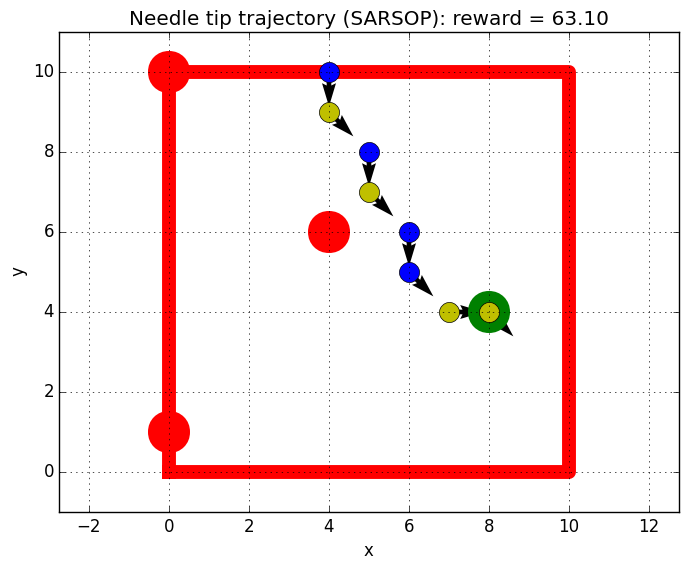

Total discounted reward: 63.10213823515623
Target reached


In [42]:
init_state = initial_state_distribution(pomdp, NeedleState(4,10,7))
hist_SARSOP = HistoryRecorder(max_steps=100)
r = simulate(hist_SARSOP, pomdp, policy, updater(policy), init_state)

println("Total discounted reward: $r")

if hist_SARSOP.state_hist[end].x == pomdp.reward_states[1].x && hist_SARSOP.state_hist[end].y == pomdp.reward_states[1].y
    println("Target reached")
else
    println("Target missed")
end
# define tissue environment
plot([0 10 10 0 0]',[0 0 10 10 0]',linewidth=10,color="r") # tissue bounds
plot(pomdp.reward_states[1].x,pomdp.reward_states[1].y,marker="o",markersize=30,color="g",markeredgecolor="none")
plot(pomdp.reward_states[9].x,pomdp.reward_states[9].y,marker="o",markersize=30,color="r",markeredgecolor="none")
# plot(pomdp.reward_states[18].x,pomdp.reward_states[18].y,marker="o",markersize=30,color="r",markeredgecolor="none")
# plot(pomdp.reward_states[27].x,pomdp.reward_states[27].y,marker="o",markersize=30,color="r",markeredgecolor="none")


# needle trajectory
steps = length(hist_SARSOP.state_hist)
for i = 1:steps-1 
    state = hist_SARSOP.state_hist[i]
    action = hist_SARSOP.action_hist[i]
    if action == :cw
        c = "y"
    else
        c = "b"
    end
    plot(state.x,state.y,color=c,marker="o",markersize=15)
    quiver(state.x,state.y,0.5*cos((state.psi-1)*pi/4),0.5*sin((state.psi-1)*pi/4))
end

title(@sprintf("Needle tip trajectory (SARSOP): reward = %0.2f",r))
axis("equal")
axis([-1, 11, -1, 11])
xlabel("x")
ylabel("y")
grid(true)

savefig("SARSOP plot")

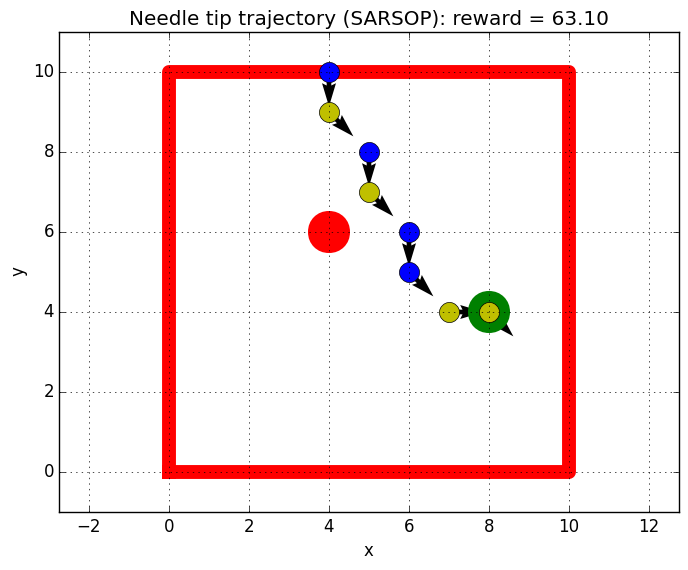

In [44]:
plot([0 10 10 0 0]',[0 0 10 10 0]',linewidth=10,color="r") # tissue bounds
plot(pomdp.reward_states[1].x,pomdp.reward_states[1].y,marker="o",markersize=30,color="g",markeredgecolor="none")
plot(pomdp.reward_states[9].x,pomdp.reward_states[9].y,marker="o",markersize=30,color="r",markeredgecolor="none")
# plot(pomdp.reward_states[18].x,pomdp.reward_states[18].y,marker="o",markersize=30,color="r",markeredgecolor="none")
# plot(pomdp.reward_states[27].x,pomdp.reward_states[27].y,marker="o",markersize=30,color="r",markeredgecolor="none")


# needle trajectory
steps = length(hist_SARSOP.state_hist)
for i = 1:steps-1 
    state = hist_SARSOP.state_hist[i]
    action = hist_SARSOP.action_hist[i]
    if action == :cw
        c = "y"
    else
        c = "b"
    end
    plot(state.x,state.y,color=c,marker="o",markersize=15)
    quiver(state.x,state.y,0.5*cos((state.psi-1)*pi/4),0.5*sin((state.psi-1)*pi/4))
end

title(@sprintf("Needle tip trajectory (SARSOP): reward = %0.2f",r))
axis("equal")
axis([-1, 11, -1, 11])
xlabel("x")
ylabel("y")
grid(true)
savefig("SARSOP plot")

In [40]:
# # save the policy
filename = "SARSOP small policy disct =0.95"
JLD.save(string(filename,".jld"),"policy",policy)

In [ ]:
using SARSOP
filename = "SARSOP large policy disct =0.95"
policy=JLD.load(string(filename,".jld"),"policy")